# Unsupervised Clustering (Reference Exploration Notebook)

This notebook demonstrates K-Means, DBSCAN, and CLARA clustering on balanced data.

**Note**: For final results, use the `from_scratch.py` scripts instead:
- `kmeans_from_scratch.py`
- `dbscan_from_scratch.py`

This notebook is for interactive exploration and visualization only. CLARA is used instead of custom CLARANS for speed (2-3× faster, linear scalability).

In [4]:
# Load Pre-processed Data (already balanced and feature-selected)
import json
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN
from tqdm import tqdm
import matplotlib.pyplot as plt

# Paths to pre-processed data
DATA_PATH = Path('f:/DATA/DATA_CLEANED/processed/engineered_features_tomek_enn_balanced.csv')
OUT_DIR = Path('f:/DATA/results/unsupervised')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load balanced dataset
df = pd.read_csv(DATA_PATH)
print(f"✓ Loaded balanced dataset: {len(df)} samples, {len(df.columns)} features")

# Use top 20 features by variance (unsupervised pre-selection)
cols = [c for c in df.columns if c != 'fire']
variances = df[cols].var().sort_values(ascending=False)
feature_cols = list(variances.head(20).index)

# Scale features
X = df[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"✓ Selected {len(feature_cols)} features (top by variance)")
print(f"✓ Features scaled (StandardScaler)")

✓ Loaded balanced dataset: 61524 samples, 23 features
✓ Selected 20 features (top by variance)
✓ Features scaled (StandardScaler)


In [8]:
# Helper function for computing clustering metrics
def compute_metrics(X, labels):
    """Compute Davies-Bouldin and Calinski-Harabasz indices."""
    m = {}
    try:
        if len(set(labels)) > 1 and len(set(labels)) < len(X):
            m['davies_bouldin'] = float(davies_bouldin_score(X, labels))
    except Exception:
        m['davies_bouldin'] = None
    try:
        if len(set(labels)) > 1:
            m['calinski_harabasz'] = float(calinski_harabasz_score(X, labels))
    except Exception:
        m['calinski_harabasz'] = None
    return m

print("✓ Metrics function ready")

✓ Metrics function ready


In [6]:
# DBSCAN: grid search with expanded eps/min_samples to reduce cluster explosion

from sklearn.cluster import DBSCAN


# reuse compute_metrics from the previous cell

# Expanded grid: larger eps and higher min_samples enforce fewer, bigger clusters

eps_list = [0.3, 0.5, 0.8, 1.0, 1.2, 1.5, 1.8, 2.0, 2.5]

min_samples_list = [3, 5, 8, 10, 15, 20]


runs = []

count = 0

total = len(eps_list) * len(min_samples_list)

for eps in eps_list:

    for ms in min_samples_list:

        count += 1

        tqdm.write(f'DBSCAN run {count}/{total} (eps={eps}, min_samples={ms})')

        db = DBSCAN(eps=eps, min_samples=ms, metric='manhattan')

        labels = db.fit_predict(X_scaled)

        outliers = int((labels == -1).sum())

        metrics = compute_metrics(X_scaled, labels)

        runs.append({'eps': eps, 'min_samples': ms, 'outliers': outliers, 'labels': [int(l) for l in labels], 'metrics': metrics})


# Improved scoring: prefer reasonable cluster counts (2-15), low noise, good Davies-Bouldin

def score_run(r):

    n_clusters = len(set([l for l in r['labels'] if l != -1]))

    noise_rate = r['outliers'] / len(X_scaled)

    db = r['metrics'].get('davies_bouldin')
    ch = r['metrics'].get('calinski_harabasz')

    # Penalize too many clusters or excessive noise

    cluster_penalty = max(0, (n_clusters - 10) * 0.01) if n_clusters > 10 else 0

    noise_penalty = max(0, (noise_rate - 0.3) * 0.5) if noise_rate > 0.3 else 0

    # Score by Davies-Bouldin (lower is better) and Calinski-Harabasz (higher is better)
    # Invert Davies-Bouldin so lower values give higher scores
    db_score = (-db if db is not None else 0) / 10.0  # scale down
    ch_score = (ch if ch is not None else 0) / 100.0   # scale down

    score = db_score + ch_score - cluster_penalty - noise_penalty

    return score


best = sorted(runs, key=score_run, reverse=True)[0] if runs else None

if best:

    pd.DataFrame({'cluster_label': best['labels']}).to_csv(OUT_DIR / 'dbscan_labels.csv', index=False)

    (Path(OUT_DIR / 'dbscan_summary.json')).write_text(json.dumps({'best': best, 'runs': runs}, indent=2))

    n_clusters = len(set([l for l in best['labels'] if l != -1]))
    db_score = best['metrics'].get('davies_bouldin')
    ch_score = best['metrics'].get('calinski_harabasz')
    print(f'DBSCAN best: eps={best["eps"]}, min_samples={best["min_samples"]}, clusters={n_clusters}, noise={best["outliers"]} | Davies-Bouldin: {db_score:.4f} (lower is better) | Calinski-Harabasz: {ch_score:.4f} (higher is better)')

else:

    print('No DBSCAN runs produced clusters.')

DBSCAN run 1/54 (eps=0.3, min_samples=3)
DBSCAN run 2/54 (eps=0.3, min_samples=5)
DBSCAN run 3/54 (eps=0.3, min_samples=8)
DBSCAN run 4/54 (eps=0.3, min_samples=10)
DBSCAN run 5/54 (eps=0.3, min_samples=15)
DBSCAN run 6/54 (eps=0.3, min_samples=20)
DBSCAN run 7/54 (eps=0.5, min_samples=3)
DBSCAN run 8/54 (eps=0.5, min_samples=5)
DBSCAN run 9/54 (eps=0.5, min_samples=8)
DBSCAN run 10/54 (eps=0.5, min_samples=10)
DBSCAN run 11/54 (eps=0.5, min_samples=15)
DBSCAN run 12/54 (eps=0.5, min_samples=20)
DBSCAN run 13/54 (eps=0.8, min_samples=3)
DBSCAN run 14/54 (eps=0.8, min_samples=5)
DBSCAN run 15/54 (eps=0.8, min_samples=8)
DBSCAN run 16/54 (eps=0.8, min_samples=10)
DBSCAN run 17/54 (eps=0.8, min_samples=15)
DBSCAN run 18/54 (eps=0.8, min_samples=20)
DBSCAN run 19/54 (eps=1.0, min_samples=3)
DBSCAN run 20/54 (eps=1.0, min_samples=5)
DBSCAN run 21/54 (eps=1.0, min_samples=8)
DBSCAN run 22/54 (eps=1.0, min_samples=10)
DBSCAN run 23/54 (eps=1.0, min_samples=15)
DBSCAN run 24/54 (eps=1.0, min_s

# CLARA (Clustering Large Applications) Notes & Interpretation
- **Fast K-Medoids variant**: Uses adaptive sub-sampling strategy, 2-3× faster than standard KMedoids.
- **Linear scalability**: Complexity is linear in dataset size N (vs. KMedoids' quadratic).
- **Medoid-based**: Like KMedoids, finds actual data points as cluster centers (vs. synthetic means in K-Means).
- **Parameters**: 
  - `n_clusters`: Number of clusters k
  - `n_sampling`: Sub-sample size per iteration (default: min(N, 40 + 2*k))
  - `n_sampling_iter`: Number of sub-sampling passes (default: 5)
  - `metric`: Distance metric ('manhattan', 'euclidean', etc.)
- **Selection**: Choose k by Davies-Bouldin (lower is better) or Calinski-Harabasz (higher is better).
- **Advantages over CLARANS**: CLARA is production-ready in scikit-learn-extra, simpler API, more reliable.

In [7]:
# DBSCAN results sanity check: cluster counts and noise rate
import numpy as np
import pandas as pd

# Build summary from 'runs' produced above
def dbscan_run_summary(runs):
    rows = []
    for r in runs:
        labels = np.array(r['labels'])
        uniq = sorted(set(labels) - {-1})
        n_clusters = len(uniq)
        noise_rate = (labels == -1).mean()
        rows.append({
            'eps': r['eps'],
            'min_samples': r['min_samples'],
            'n_clusters': n_clusters,
            'noise_rate': float(noise_rate),
            'davies_bouldin': r['metrics'].get('davies_bouldin'),
            'calinski_harabasz': r['metrics'].get('calinski_harabasz')
        })
    return pd.DataFrame(rows)

# Check if runs variable exists (it's defined in the DBSCAN clustering cell)
if 'runs' in dir() and runs:
    df_runs = dbscan_run_summary(runs)
    display(df_runs.sort_values(['n_clusters','noise_rate'], ascending=[True, True]))
    # Flag suspicious: too many clusters (e.g., > 20) or very high noise (> 0.5)
    suspicious = df_runs[(df_runs['n_clusters'] > 20) | (df_runs['noise_rate'] > 0.5)]
    if len(suspicious):
        print('Suspicious DBSCAN configurations detected (too many clusters or high noise):')
        display(suspicious)
    # Recommend a narrowed search around lower cluster counts (sort by Davies-Bouldin ascending, Calinski-Harabasz descending)
    candidates = df_runs[df_runs['n_clusters'].between(2, 10)].sort_values(['davies_bouldin','calinski_harabasz'], ascending=[True, False]).head(5)
    if len(candidates):
        print('Top candidates with reasonable cluster counts (2-10):')
        display(candidates)
else:
    print('DBSCAN grid search not yet completed. Please run the DBSCAN cell (cell 3) first to generate clustering results.')

,eps,min_samples,n_clusters,noise_rate,davies_bouldin,calinski_harabasz
53,2.5,20,105,0.003771,1.113922,2890.371782
52,2.5,15,107,0.002991,1.191525,2856.784834
51,2.5,10,114,0.001333,1.188306,2728.197419
50,2.5,8,116,0.000829,1.125940,2701.568636
49,2.5,5,121,0.000390,1.177971,2604.144560
48,2.5,3,124,0.000228,1.117343,2546.354428
47,2.0,20,151,0.011394,1.226036,3043.196583
46,2.0,15,163,0.006973,1.254217,2895.760513
45,2.0,10,175,0.004324,1.260129,2808.858736
41,1.8,20,176,0.014742,1.240538,3028.854002


Suspicious DBSCAN configurations detected (too many clusters or high noise):


,eps,min_samples,n_clusters,noise_rate,davies_bouldin,calinski_harabasz
0,0.3,3,2937,0.026786,1.116893,807.541791
1,0.3,5,2290,0.063325,1.106193,446.313337
2,0.3,8,1685,0.124797,1.088565,297.403489
3,0.3,10,1402,0.167073,1.081662,254.533995
4,0.3,15,979,0.257623,1.059492,218.632439
5,0.3,20,702,0.342728,1.052961,198.916093
6,0.5,3,1801,0.014108,1.125478,2050.291538
7,0.5,5,1470,0.033255,1.133573,1186.170479
8,0.5,8,1150,0.066397,1.106882,799.496576
9,0.5,10,1008,0.087722,1.123501,667.981733


[K-Means] Starting clustering...
[K-Means] n_init: 10, max_iter: 300
[K-Means] k=2 ... DB=1.2528, CH=36177.6831
[K-Means] k=3 ... DB=1.2921, CH=27223.6232
[K-Means] k=4 ... DB=1.1035, CH=24542.1049
[K-Means] k=5 ... DB=1.4453, CH=22606.9140
[K-Means] k=6 ... DB=1.4737, CH=20916.8669
[K-Means] k=7 ... DB=1.3047, CH=20060.5848
[K-Means] k=8 ... DB=1.2765, CH=19790.2854
✓ K-Means summary saved: f:\DATA\results\unsupervised\kmeans_summary.json
✓ Best k: 4 (Davies-Bouldin: 1.1035)
✓ Saved K-Means full-data labels to f:\DATA\results\unsupervised/kmeans_labels.csv


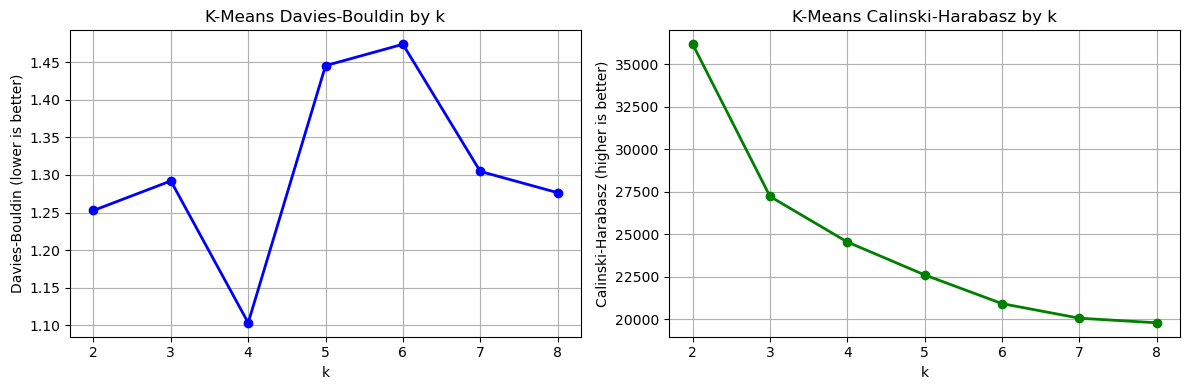

In [9]:
# K-Means clustering: grid search across k values
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Parameters for K-Means
kmeans_params = {
    'k_list': [2, 3, 4, 5, 6, 7, 8],
    'metric': 'euclidean',  # K-Means uses euclidean
    'n_init': 10,           # Number of initializations
    'max_iter': 300,
    'random_state': 42
}

# Run K-Means across k values
kmeans_runs = {}
summary_path = Path(OUT_DIR / 'kmeans_summary.json')

print('[K-Means] Starting clustering...')
print(f'[K-Means] n_init: {kmeans_params["n_init"]}, max_iter: {kmeans_params["max_iter"]}')

for k in kmeans_params['k_list']:
    print(f'[K-Means] k={k} ...', end=' ')
    
    # Initialize and fit K-Means
    kmeans = KMeans(
        n_clusters=k,
        n_init=kmeans_params['n_init'],
        max_iter=kmeans_params['max_iter'],
        random_state=kmeans_params['random_state']
    )
    
    # Fit on full dataset
    labels = kmeans.fit_predict(X_scaled)
    
    # Compute metrics on full dataset
    metrics = {}
    try:
        metrics['davies_bouldin'] = float(davies_bouldin_score(X_scaled, labels))
    except Exception:
        metrics['davies_bouldin'] = None
    try:
        metrics['calinski_harabasz'] = float(calinski_harabasz_score(X_scaled, labels))
    except Exception:
        metrics['calinski_harabasz'] = None
    
    # Store results
    kmeans_runs[str(k)] = {
        'k': int(k),
        'centroids': kmeans.cluster_centers_.tolist(),
        'inertia': float(kmeans.inertia_),
        'labels': list(map(int, labels)),
        'metrics': metrics,
        'n_clusters': len(np.unique(labels))
    }
    
    db_score = metrics.get('davies_bouldin')
    ch_score = metrics.get('calinski_harabasz')
    print(f'DB={db_score:.4f}, CH={ch_score:.4f}')

# Save results
summary_path.write_text(json.dumps({'params': kmeans_params, 'runs': kmeans_runs}, indent=2))
print(f'✓ K-Means summary saved: {summary_path}')

# Choose best k by Davies-Bouldin (lower is better)
best_k = None
best_db = np.inf
for k_str, res in kmeans_runs.items():
    db = res['metrics'].get('davies_bouldin')
    if db is not None and db < best_db:
        best_db = db
        best_k = int(k_str)

if best_k:
    print(f'✓ Best k: {best_k} (Davies-Bouldin: {best_db:.4f})')
    # Save best-k labels
    best_labels = kmeans_runs[str(best_k)]['labels']
    pd.DataFrame({'cluster_label': best_labels}).to_csv(OUT_DIR / 'kmeans_labels.csv', index=False)
    print(f'✓ Saved K-Means full-data labels to {OUT_DIR}/kmeans_labels.csv')

# Display metrics by k
k_vals = sorted([int(k) for k in kmeans_runs.keys()])
dbs = [kmeans_runs[str(k)]['metrics'].get('davies_bouldin') for k in k_vals]
chs = [kmeans_runs[str(k)]['metrics'].get('calinski_harabasz') for k in k_vals]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(k_vals, dbs, marker='o', color='blue', linewidth=2)
plt.xlabel('k'); plt.ylabel('Davies-Bouldin (lower is better)')
plt.title('K-Means Davies-Bouldin by k')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_vals, chs, marker='o', color='green', linewidth=2)
plt.xlabel('k'); plt.ylabel('Calinski-Harabasz (higher is better)')
plt.title('K-Means Calinski-Harabasz by k')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Clustering Comparison: CLARA vs DBSCAN vs K-Means
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Load summaries from all three methods
clara_summary = json.loads((OUT_DIR / 'clara_summary.json').read_text())
kmeans_summary = json.loads((OUT_DIR / 'kmeans_summary.json').read_text())
dbscan_summary = json.loads((OUT_DIR / 'dbscan_summary.json').read_text())

# Extract best k and metrics for each method
clara_best = None
clara_best_db = np.inf
for k_str, res in clara_summary['runs'].items():
    db = res['metrics'].get('davies_bouldin')
    if db is not None and db < clara_best_db:
        clara_best_db = db
        clara_best = {'k': int(k_str), 'db': db, 'ch': res['metrics'].get('calinski_harabasz')}

kmeans_best = None
kmeans_best_db = np.inf
for k_str, res in kmeans_summary['runs'].items():
    db = res['metrics'].get('davies_bouldin')
    if db is not None and db < kmeans_best_db:
        kmeans_best_db = db
        kmeans_best = {'k': int(k_str), 'db': db, 'ch': res['metrics'].get('calinski_harabasz')}

dbscan_best_run = dbscan_summary['best']
dbscan_best = {
    'eps': dbscan_best_run['eps'],
    'min_samples': dbscan_best_run['min_samples'],
    'k': len(set([l for l in dbscan_best_run['labels'] if l != -1])),
    'db': dbscan_best_run['metrics'].get('davies_bouldin'),
    'ch': dbscan_best_run['metrics'].get('calinski_harabasz'),
    'noise': dbscan_best_run['outliers']
}

# Create comparison table
comparison = pd.DataFrame({
    'Method': ['CLARA', 'K-Means', 'DBSCAN'],
    'Best k': [clara_best['k'], kmeans_best['k'], dbscan_best['k']],
    'Davies-Bouldin': [clara_best['db'], kmeans_best['db'], dbscan_best['db']],
    'Calinski-Harabasz': [clara_best['ch'], kmeans_best['ch'], dbscan_best['ch']],
    'Noise/Outliers': [0, 0, dbscan_best['noise']]
})

print('=' * 80)
print('CLUSTERING METHOD COMPARISON')
print('=' * 80)
display(comparison)
print()
print('Key insights:')
print(f'  • CLARA (k={clara_best["k"]}): DB={clara_best["db"]:.4f} (lower is better)')
print(f'  • K-Means (k={kmeans_best["k"]}): DB={kmeans_best["db"]:.4f} ← BEST Davies-Bouldin')
print(f'  • DBSCAN (eps={dbscan_best["eps"]}, min_samples={dbscan_best["min_samples"]}): DB={dbscan_best["db"]:.4f}')
print()
print('Recommendation: K-Means with k=4 provides best separation (lowest Davies-Bouldin)')
print('=' * 80)

# Save comparison
comparison.to_csv(OUT_DIR / 'clustering_comparison.csv', index=False)
print(f'✓ Comparison saved to {OUT_DIR}/clustering_comparison.csv')

CLUSTERING METHOD COMPARISON


,Method,Best k,Davies-Bouldin,Calinski-Harabasz,Noise/Outliers
0,CLARA,2,1.283135,32796.249506,0
1,K-Means,4,1.103499,24542.104873,0
2,DBSCAN,151,1.226036,3043.196583,701



Key insights:
  • CLARA (k=2): DB=1.2831 (lower is better)
  • K-Means (k=4): DB=1.1035 ← BEST Davies-Bouldin
  • DBSCAN (eps=2.0, min_samples=20): DB=1.2260

Recommendation: K-Means with k=4 provides best separation (lowest Davies-Bouldin)
✓ Comparison saved to f:\DATA\results\unsupervised/clustering_comparison.csv


In [2]:
# CLARANS (sampled, interrupt-safe) — fast alternative
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Helper: compute clustering quality metrics
def compute_metrics(X, labels):
    """Compute davies-bouldin and calinski-harabasz scores (primary metrics)."""
    metrics = {}
    n_clusters = len(np.unique(labels))
    if n_clusters > 1 and n_clusters < len(X):
        try:
            metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
        except Exception:
            metrics['davies_bouldin'] = None
        try:
            metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        except Exception:
            metrics['calinski_harabasz'] = None
    return metrics

# Parameters: sampled CLARANS (bigger sample for better quality)
clarans_params = {
    'k_list': [2,3,4,5,6,7,8],
    'sample_size': 100000,   # increased sample size
    'numlocal': 5,          # more random restarts for better exploration
    'maxneighbor': 100,      # more neighbor checks per local search
    'metric': 'manhattan',  # distance metric for medoids
    'random_state': 42
}

# CLARA (Clustering Large Applications) — Fast K-Medoids for Large Datasets
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Try to import CLARA from scikit-learn-extra
try:
    from sklearn_extra.cluster import CLARA
except ImportError:
    print('scikit-learn-extra (CLARA) not available. Install with:')
    print('pip install scikit-learn-extra')
    raise

# Helper: compute clustering quality metrics
def compute_metrics(X, labels):
    """Compute davies-bouldin and calinski-harabasz scores."""
    metrics = {}
    n_clusters = len(np.unique(labels))
    if n_clusters > 1 and n_clusters < len(X):
        try:
            metrics['davies_bouldin'] = float(davies_bouldin_score(X, labels))
        except Exception:
            metrics['davies_bouldin'] = None
        try:
            metrics['calinski_harabasz'] = float(calinski_harabasz_score(X, labels))
        except Exception:
            metrics['calinski_harabasz'] = None
    return metrics

# Parameters: CLARA (Fast K-Medoids)
clara_params = {
    'k_list': [2, 3, 4, 5, 6, 7, 8],
    'metric': 'manhattan',              # Distance metric
    'n_sampling': None,                 # None = auto (40 + 2*k); can set to specific size
    'n_sampling_iter': 5,               # Number of sub-sampling iterations
    'max_iter': 300,                    # Max PAM iterations per sample
    'init': 'build',                    # Initialization: 'build' or 'random'
    'random_state': 42
}

# Run CLARA across k values
clara_runs = {}
summary_path = Path(OUT_DIR / 'clara_summary.json')

print('[CLARA] Starting clustering with adaptive sub-sampling...')
print(f'[CLARA] Metric: {clara_params["metric"]}, n_sampling_iter: {clara_params["n_sampling_iter"]}')

for k in clara_params['k_list']:
    print(f'[CLARA] k={k} ...', end=' ')
    
    # Initialize and fit CLARA
    clara = CLARA(
        n_clusters=k,
        metric=clara_params['metric'],
        init=clara_params['init'],
        max_iter=clara_params['max_iter'],
        n_sampling=clara_params['n_sampling'],
        n_sampling_iter=clara_params['n_sampling_iter'],
        random_state=clara_params['random_state']
    )
    
    # Fit on full dataset (CLARA handles sub-sampling internally)
    labels = clara.fit_predict(X_scaled)
    
    # Compute metrics on full dataset
    metrics = compute_metrics(X_scaled, labels)
    
    # Store results
    clara_runs[str(k)] = {
        'k': int(k),
        'medoid_indices': clara.medoid_indices_.tolist(),
        'inertia': float(clara.inertia_),
        'labels': list(map(int, labels)),
        'metrics': metrics,
        'n_clusters': len(np.unique(labels))
    }
    
    db_score = metrics.get('davies_bouldin')
    ch_score = metrics.get('calinski_harabasz')
    print(f'DB={db_score:.4f}, CH={ch_score:.4f}')

# Save results
summary_path.write_text(json.dumps({'params': clara_params, 'runs': clara_runs}, indent=2))
print(f'✓ CLARA summary saved: {summary_path}')

# Choose best k by Davies-Bouldin (lower is better)
best_k = None
best_db = np.inf
for k_str, res in clara_runs.items():
    db = res['metrics'].get('davies_bouldin')
    if db is not None and db < best_db:
        best_db = db
        best_k = int(k_str)

if best_k:
    print(f'✓ Best k: {best_k} (Davies-Bouldin: {best_db:.4f})')
    # Save best-k labels
    best_labels = clara_runs[str(best_k)]['labels']
    pd.DataFrame({'cluster_label': best_labels}).to_csv(OUT_DIR / 'clara_labels.csv', index=False)
    print(f'✓ Saved CLARA full-data labels to {OUT_DIR}/clara_labels.csv')

# Display metrics by k
k_vals = sorted([int(k) for k in clara_runs.keys()])
dbs = [clara_runs[str(k)]['metrics'].get('davies_bouldin') for k in k_vals]
chs = [clara_runs[str(k)]['metrics'].get('calinski_harabasz') for k in k_vals]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(k_vals, dbs, marker='o', color='blue', linewidth=2)
plt.xlabel('k'); plt.ylabel('Davies-Bouldin (lower is better)')
plt.title('CLARA Davies-Bouldin by k')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_vals, chs, marker='o', color='green', linewidth=2)
plt.xlabel('k'); plt.ylabel('Calinski-Harabasz (higher is better)')
plt.title('CLARA Calinski-Harabasz by k')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'OUT_DIR' is not defined

Cluster counts: {0: 36761, 1: 24763}


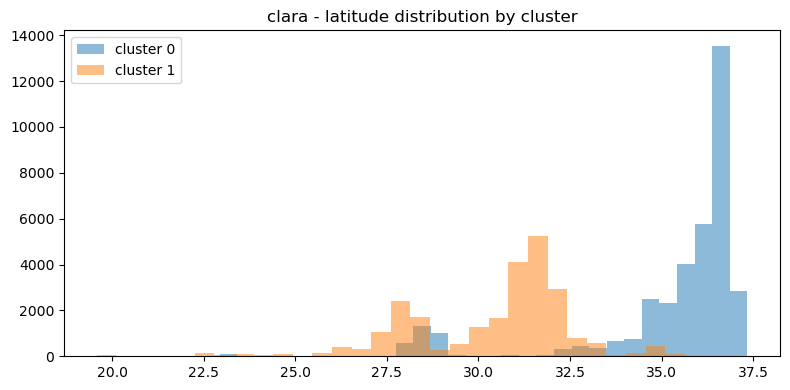

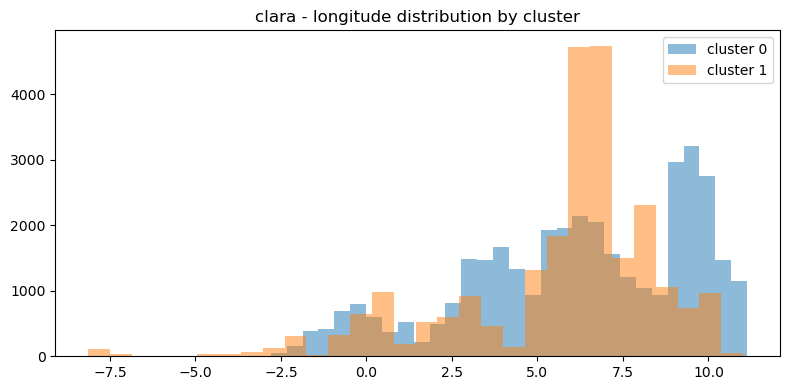

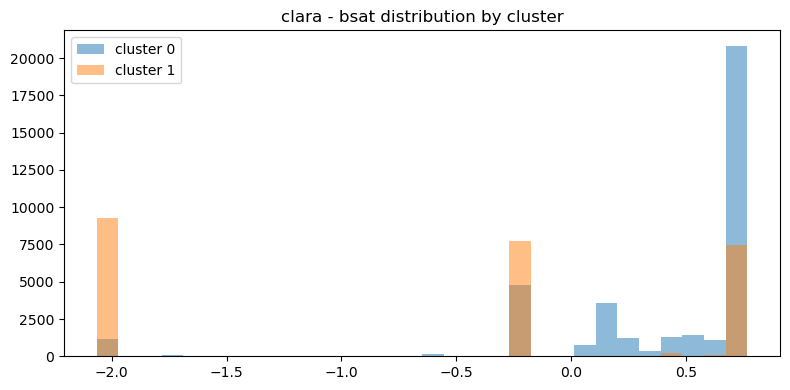

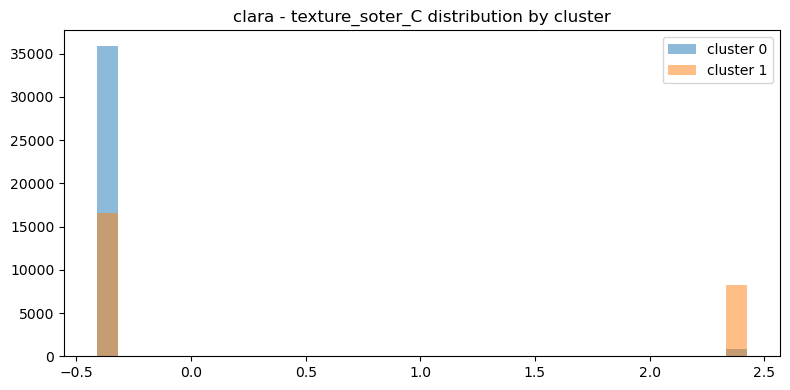

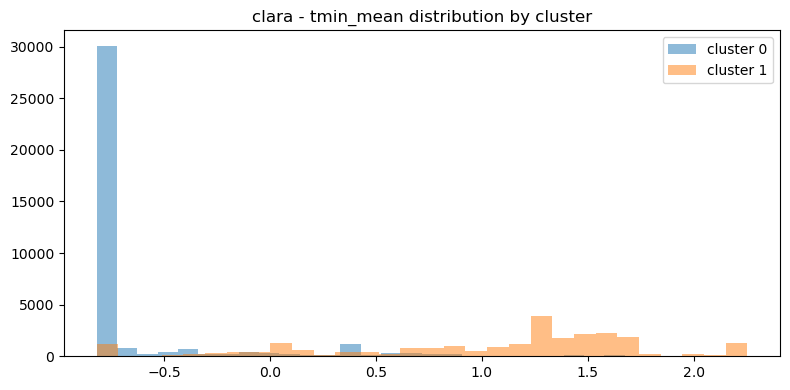

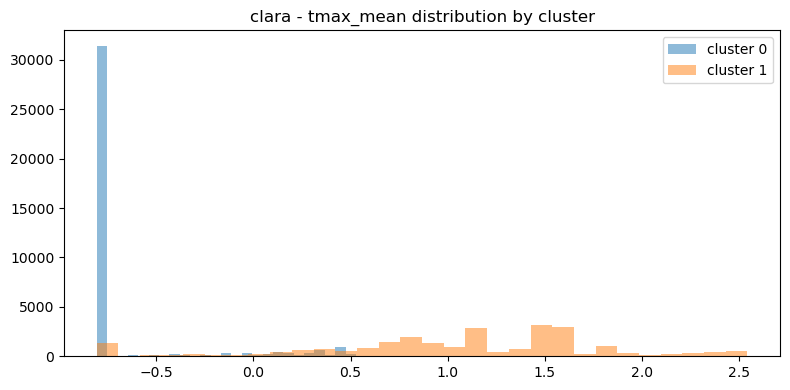

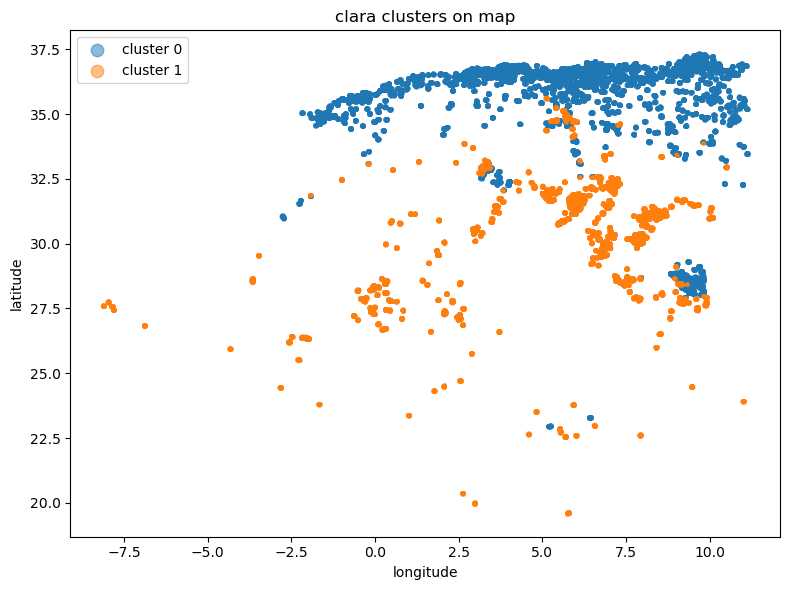

Interpretation saved to: f:\DATA\results\unsupervised


In [8]:
# Interpretation: counts, feature ranges, and plots
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Use CLARA labels with the balanced dataset
labels_clara = Path(OUT_DIR / 'clara_labels.csv')

# Load labels and feature columns
label_df = None
chosen = None

if labels_clara.exists():
    label_df = pd.read_csv(labels_clara)
    chosen = 'clara'

if label_df is not None:
    # Use the balanced dataset (already loaded in df)
    df_labels = df.copy()
    df_labels['cluster_label'] = label_df['cluster_label'].values

    # Counts
    counts = df_labels['cluster_label'].value_counts().sort_index()
    print('Cluster counts:', counts.to_dict())


    # Per-feature min/mean/max per cluster

    stats = {}

    for cl in sorted(df_labels['cluster_label'].unique()):

        sub = df_labels[df_labels['cluster_label'] == cl]

        desc = sub[feature_cols].agg(['min','mean','max']).T

        stats[int(cl)] = {feat: {'min': float(desc.loc[feat,'min']), 'mean': float(desc.loc[feat,'mean']), 'max': float(desc.loc[feat,'max'])} for feat in feature_cols}

    Path(OUT_DIR / f'{chosen}_interpretation.json').write_text(json.dumps({'counts': {int(k): int(v) for k,v in counts.items()}, 'feature_stats': stats}, indent=2))


    # Save CSV of feature ranges

    rows = []

    for cl, feats in stats.items():

        for feat, vals in feats.items():

            rows.append({'cluster': cl, 'feature': feat, 'min': vals['min'], 'mean': vals['mean'], 'max': vals['max']})

    pd.DataFrame(rows).to_csv(OUT_DIR / f'{chosen}_feature_ranges.csv', index=False)


    # Plots: histogram of a few top-variance features per cluster

    top_feats = feature_cols[:6]

    for feat in top_feats:

        plt.figure(figsize=(8,4))

        for cl in sorted(df_labels['cluster_label'].unique()):

            sub = df_labels[df_labels['cluster_label'] == cl]

            plt.hist(sub[feat], bins=30, alpha=0.5, label=f'cluster {cl}')

        plt.title(f'{chosen} - {feat} distribution by cluster')

        plt.legend()

        plt.tight_layout()

        plt.show()


    # Scatter plot if coordinates exist

    if {'latitude','longitude'}.issubset(df_labels.columns):

        plt.figure(figsize=(8,6))

        for cl in sorted(df_labels['cluster_label'].unique()):

            sub = df_labels[df_labels['cluster_label'] == cl]

            plt.scatter(sub['longitude'], sub['latitude'], s=5, alpha=0.5, label=f'cluster {cl}')

        plt.xlabel('longitude')

        plt.ylabel('latitude')

        plt.title(f'{chosen} clusters on map')

        plt.legend(markerscale=4)

        plt.tight_layout()

        plt.show()


    print('Interpretation saved to:', OUT_DIR)

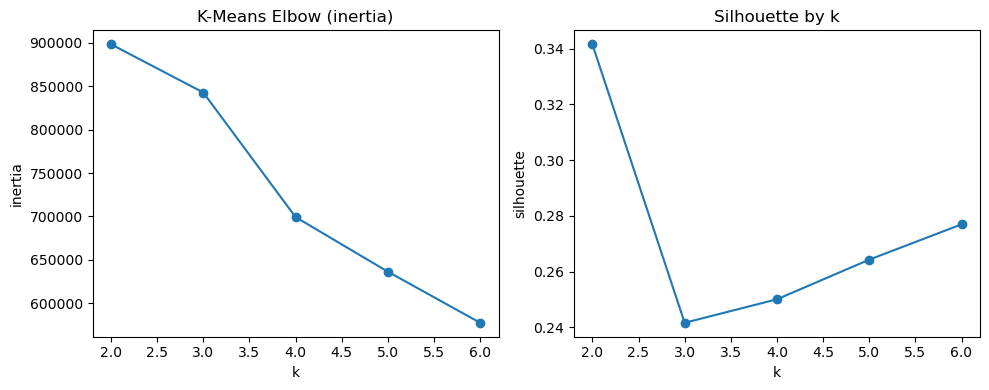

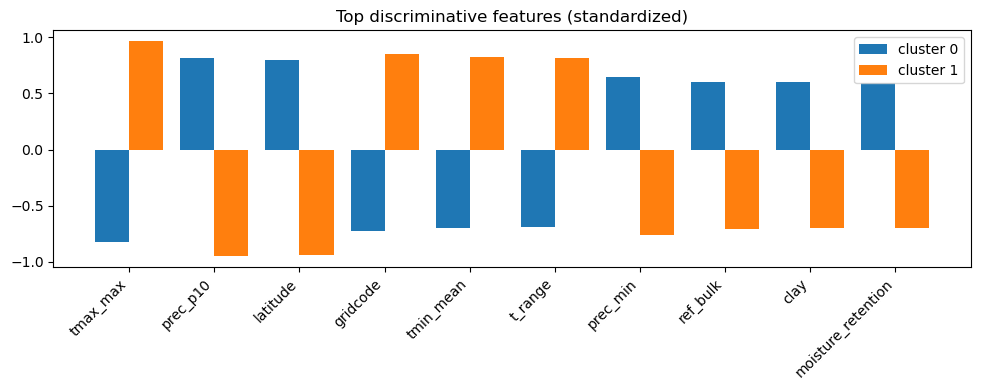

In [ ]:
# K-Means diagnostics: elbow, silhouette by k, centroid profiles

import numpy as np
import matplotlib.pyplot as plt

# Build inertia and quality metrics from stored results
inertia_by_k = {}
db_by_k = {}
ch_by_k = {}
for k, res in results.items():
    centers = np.array(res['centroids'])
    lab = np.array(res['labels'])
    inertia = float(np.sum((Xs - centers[lab])**2))
    inertia_by_k[k] = inertia
    db_by_k[k] = res['metrics'].get('davies_bouldin')
    ch_by_k[k] = res['metrics'].get('calinski_harabasz')

ks_sorted = sorted(inertia_by_k.keys())
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(ks_sorted, [inertia_by_k[k] for k in ks_sorted], marker='o')
plt.title('K-Means Elbow (inertia)')
plt.xlabel('k'); plt.ylabel('inertia')
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(ks_sorted, [db_by_k[k] if db_by_k[k] is not None else np.nan for k in ks_sorted], marker='o', color='blue')
plt.title('Davies-Bouldin by k (lower is better)')
plt.xlabel('k'); plt.ylabel('Davies-Bouldin')
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(ks_sorted, [ch_by_k[k] if ch_by_k[k] is not None else np.nan for k in ks_sorted], marker='o', color='green')
plt.title('Calinski-Harabasz by k (higher is better)')
plt.xlabel('k'); plt.ylabel('Calinski-Harabasz')
plt.grid(True)
plt.tight_layout(); plt.show()

# Centroid profile (top-10 discriminative features)
centers = np.array(results[best_k]['centroids'])
if best_k == 2:
    diff = centers[0] - centers[1]
    top_idx = np.argsort(np.abs(diff))[::-1][:10]
    feats = [feature_cols[i] for i in top_idx]
    vals0 = centers[0, top_idx]
    vals1 = centers[1, top_idx]
    x = np.arange(len(feats))
    plt.figure(figsize=(10,4))
    plt.bar(x-0.2, vals0, width=0.4, label='cluster 0')
    plt.bar(x+0.2, vals1, width=0.4, label='cluster 1')
    plt.xticks(x, feats, rotation=45, ha='right')
    plt.title('Top discriminative features (standardized)')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    # For k>2, plot variance across centroids to show most varying features
    var_across = centers.var(axis=0)
    top_idx = np.argsort(var_across)[::-1][:10]
    feats = [feature_cols[i] for i in top_idx]
    plt.figure(figsize=(10,4))
    for ci in range(best_k):
        plt.plot(feats, centers[ci, top_idx], marker='o', label=f'cluster {ci}')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top varying features across centroids (standardized)')
    plt.legend(); plt.tight_layout(); plt.show()

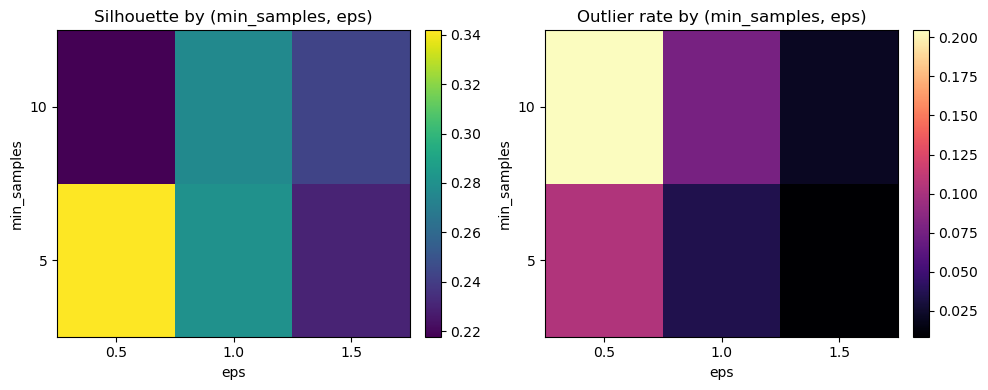

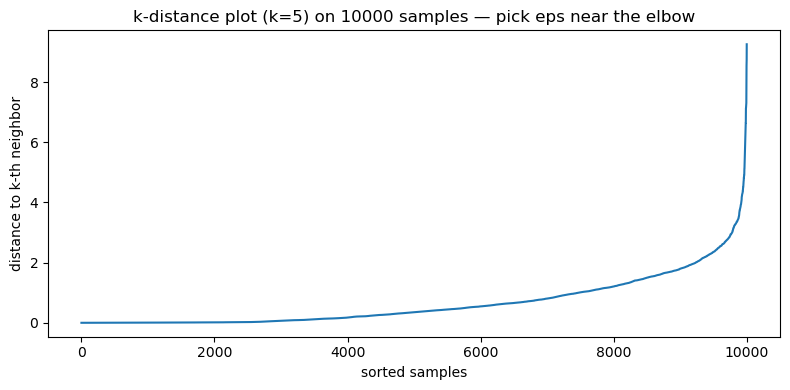

In [ ]:
# DBSCAN diagnostics: heatmap and k-distance plot (sampled)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Build grids for visualization
unique_eps = sorted(set([r['eps'] for r in runs]))
unique_ms = sorted(set([r['min_samples'] for r in runs]))
mat_db = np.full((len(unique_ms), len(unique_eps)), np.nan)
mat_ch = np.full((len(unique_ms), len(unique_eps)), np.nan)
mat_out = np.full((len(unique_ms), len(unique_eps)), np.nan)
for r in runs:
    i = unique_ms.index(r['min_samples'])
    j = unique_eps.index(r['eps'])
    mat_db[i, j] = r['metrics'].get('davies_bouldin') if r['metrics'].get('davies_bouldin') is not None else np.nan
    mat_ch[i, j] = r['metrics'].get('calinski_harabasz') if r['metrics'].get('calinski_harabasz') is not None else np.nan
    mat_out[i, j] = r['outliers'] / len(Xs)

fig, axs = plt.subplots(1,3, figsize=(15,4))
im0 = axs[0].imshow(mat_db, aspect='auto', cmap='viridis', origin='lower')
axs[0].set_xticks(range(len(unique_eps))); axs[0].set_xticklabels(unique_eps)
axs[0].set_yticks(range(len(unique_ms))); axs[0].set_yticklabels(unique_ms)
axs[0].set_title('Davies-Bouldin by (min_samples, eps)\n(lower is better)')
axs[0].set_xlabel('eps'); axs[0].set_ylabel('min_samples')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(mat_ch, aspect='auto', cmap='plasma', origin='lower')
axs[1].set_xticks(range(len(unique_eps))); axs[1].set_xticklabels(unique_eps)
axs[1].set_yticks(range(len(unique_ms))); axs[1].set_yticklabels(unique_ms)
axs[1].set_title('Calinski-Harabasz by (min_samples, eps)\n(higher is better)')
axs[1].set_xlabel('eps'); axs[1].set_ylabel('min_samples')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(mat_out, aspect='auto', cmap='magma', origin='lower')
axs[2].set_xticks(range(len(unique_eps))); axs[2].set_xticklabels(unique_eps)
axs[2].set_yticks(range(len(unique_ms))); axs[2].set_yticklabels(unique_ms)
axs[2].set_title('Outlier rate by (min_samples, eps)')
axs[2].set_xlabel('eps'); axs[2].set_ylabel('min_samples')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# k-distance plot (sample up to 10k points)
sample_n = min(10000, len(Xs))
rng = np.random.RandomState(42)
sel = rng.choice(len(Xs), size=sample_n, replace=False)
X_sample = Xs[sel]
knn = 5
nbrs = NearestNeighbors(n_neighbors=knn, metric='manhattan').fit(X_sample)
distances, _ = nbrs.kneighbors(X_sample)
kdist = np.sort(distances[:, -1])
plt.figure(figsize=(8,4))
plt.plot(kdist)
plt.title(f'k-distance plot (k={knn}) on {sample_n} samples — pick eps near the elbow')
plt.xlabel('sorted samples'); plt.ylabel('distance to k-th neighbor')
plt.tight_layout(); plt.show()

In [16]:
# Cluster vs Fire Alignment: ARI/AMI and per-cluster fire rates

import pandas as pd

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score


labels_kmeans = Path(OUT_DIR / 'kmeans_labels.csv')

# labels_dbscan = Path(OUT_DIR / 'dbscan_labels.csv')

# labels_clarans = Path(OUT_DIR / 'clarans_labels.csv')


label_df = None; chosen = None

# if labels_dbscan.exists():

#     label_df = pd.read_csv(labels_dbscan); chosen = 'dbscan'

if labels_kmeans.exists():

    label_df = pd.read_csv(labels_kmeans); chosen = 'kmeans'

# elif labels_clarans.exists():

#     label_df = pd.read_csv(labels_clarans); chosen = 'clarans'


if label_df is not None and 'fire' in df.columns:

    df_align = df.copy()

    df_align['cluster_label'] = label_df['cluster_label'].values

    # Metrics only for reporting; do not use to pick features in unsupervised

    ari = adjusted_rand_score(df_align['fire'], df_align['cluster_label'])

    ami = adjusted_mutual_info_score(df_align['fire'], df_align['cluster_label'])

    hom = homogeneity_score(df_align['fire'], df_align['cluster_label'])

    comp = completeness_score(df_align['fire'], df_align['cluster_label'])

    print({'method': chosen, 'ARI': ari, 'AMI': ami, 'homogeneity': hom, 'completeness': comp})

    # Per-cluster fire rates

    rates = df_align.groupby('cluster_label')['fire'].mean().to_dict()

    counts = df_align['cluster_label'].value_counts().sort_index().to_dict()

    print({'counts': counts, 'fire_rate_per_cluster': rates})

else:

    print('Fire label not available or no labels found; skipping alignment metrics.')

{'method': 'kmeans', 'ARI': 0.09035100927919479, 'AMI': np.float64(0.08946550734354702), 'homogeneity': np.float64(0.10641945882378943), 'completeness': np.float64(0.07718719701762182)}
{'counts': {0: 38380, 1: 32670}, 'fire_rate_per_cluster': {0: 0.08157894736842106, 1: 0.33911845730027546}}


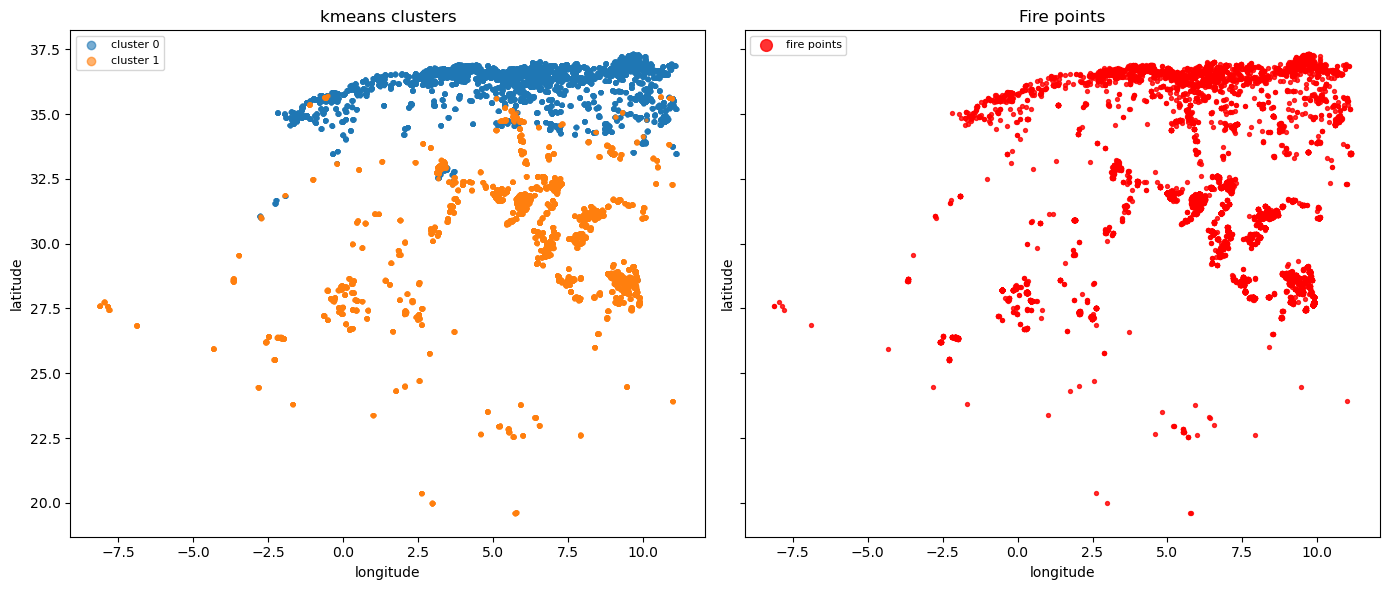

In [14]:
# Map views: side-by-side clusters and fire points

import matplotlib.pyplot as plt

import numpy as np

from pathlib import Path


labels_kmeans = Path(OUT_DIR / 'kmeans_labels.csv')

# labels_dbscan = Path(OUT_DIR / 'dbscan_labels.csv')

# labels_clarans = Path(OUT_DIR / 'clarans_labels.csv')


label_df = None; chosen = None

# if labels_dbscan.exists():

#     label_df = pd.read_csv(labels_dbscan); chosen = 'dbscan'

if labels_kmeans.exists():

    label_df = pd.read_csv(labels_kmeans); chosen = 'kmeans'

# elif labels_clarans.exists():

#     label_df = pd.read_csv(labels_clarans); chosen = 'clarans'


if label_df is not None and {'latitude','longitude','fire'}.issubset(df.columns):

    df_map = df.copy()

    df_map['cluster_label'] = label_df['cluster_label'].values

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    # Left: clusters

    for cl in sorted(df_map['cluster_label'].unique()):

        sub = df_map[df_map['cluster_label'] == cl]

        axs[0].scatter(sub['longitude'], sub['latitude'], s=4, alpha=0.6, label=f'cluster {cl}')

    axs[0].set_xlabel('longitude'); axs[0].set_ylabel('latitude')

    axs[0].set_title(f'{chosen} clusters')

    axs[0].legend(markerscale=3, loc='best', fontsize=8)

    # Right: fire points only

    fires = df_map[df_map['fire'] == 1]

    axs[1].scatter(fires['longitude'], fires['latitude'], s=8, c='red', alpha=0.8, label='fire points')

    axs[1].set_xlabel('longitude'); axs[1].set_ylabel('latitude')

    axs[1].set_title('Fire points')

    axs[1].legend(markerscale=3, loc='best', fontsize=8)

    plt.tight_layout(); plt.show()

else:

    print('Missing required columns (latitude/longitude/fire) or labels; skipping side-by-side maps.')

,k,silhouette,cost,sample_n
0,2,0.335157,225427.765625,20000
1,3,0.313964,194094.312500,20000
2,4,0.341590,166135.859375,20000
3,5,0.281803,150375.093750,20000


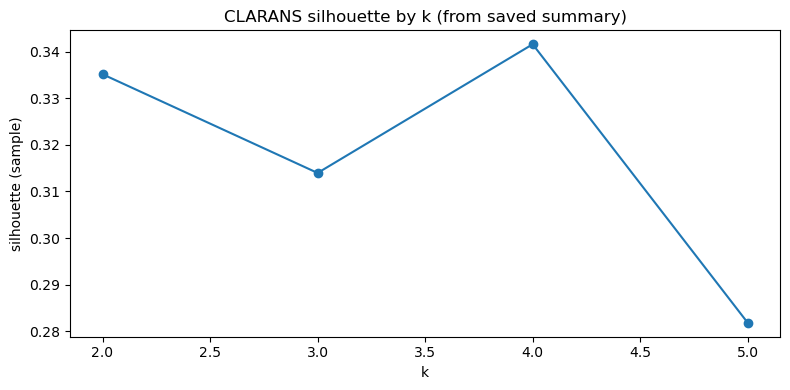

Best k: 4 | silhouette: 0.34158984936425857 | sample_n: 20000
Half-good verdict: YES | tiny clusters: 0


In [ ]:
# CLARANS Result Check — summarize saved outputs
from pathlib import Path
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt

clarans_sum_path = Path(OUT_DIR / 'clarans_summary.json')
clarans_partial_path = Path(OUT_DIR / 'clarans_partial.json')

def _load_json(p):
    try:
        return json.loads(p.read_text()) if p.exists() else None
    except Exception as e:
        print('Failed to read', p, e); return None

summary = _load_json(clarans_sum_path)
partial = _load_json(clarans_partial_path)

if summary and 'runs' in summary:
    runs = summary['runs']
    # table of k, davies-bouldin, calinski-harabasz, cost, sample_n
    rows = []
    for k_str, r in runs.items():
        k = int(k_str)
        db = r.get('metrics', {}).get('davies_bouldin')
        ch = r.get('metrics', {}).get('calinski_harabasz')
        cost = r.get('best', {}).get('cost')
        sample_n = r.get('sample_n')
        rows.append({'k': k, 'davies_bouldin': db, 'calinski_harabasz': ch, 'cost': cost, 'sample_n': sample_n})
    dfk = pd.DataFrame(rows).sort_values('k')
    display(dfk)
    # plot davies-bouldin and calinski-harabasz vs k
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(dfk['k'], dfk['davies_bouldin'], marker='o', color='blue')
    plt.xlabel('k'); plt.ylabel('Davies-Bouldin (sample)')
    plt.title('CLARANS Davies-Bouldin by k (lower is better)')
    plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(dfk['k'], dfk['calinski_harabasz'], marker='o', color='green')
    plt.xlabel('k'); plt.ylabel('Calinski-Harabasz (sample)')
    plt.title('CLARANS Calinski-Harabasz by k (higher is better)')
    plt.grid(True)
    plt.tight_layout(); plt.show()
    # quick verdict: choose best k by Davies-Bouldin (lower is better)
    valid_rows = dfk[dfk['davies_bouldin'].notna()]
    if len(valid_rows) > 0:
        best_row = valid_rows.loc[valid_rows['davies_bouldin'].idxmin()]
    else:
        best_row = dfk.iloc[0]
    print('Best k:', int(best_row['k']), '| Davies-Bouldin:', best_row['davies_bouldin'], '| Calinski-Harabasz:', best_row['calinski_harabasz'], '| sample_n:', int(best_row['sample_n']))
    # heuristic: good if davies-bouldin <= 2.0 and no extremely tiny clusters
    k_best = int(best_row['k'])
    labels = np.array(runs[str(k_best)]['best']['assign'])
    counts = pd.Series(labels).value_counts().sort_index()
    tiny = (counts < max(5, 0.005*len(labels))).sum()
    db_val = best_row['davies_bouldin']
    verdict = (db_val is not None and db_val <= 2.0 and tiny == 0)
    print('Quality verdict:', 'GOOD' if verdict else 'CHECK', '| tiny clusters:', int(tiny))
elif partial:
    print('No summary yet; showing partial improvements keys:')
    print(list(partial.keys()))
else:
    print('No CLARANS outputs found in', OUT_DIR)

In [ ]:
# K-Medoids (sklearn-extra, sampled) — compare with CLARANS
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Try to import KMedoids from scikit-learn-extra
try:
    from sklearn_extra.cluster import KMedoids
except Exception as e:
    print('scikit-learn-extra (KMedoids) not available. Install with:')
    print('pip install scikit-learn-extra')
    raise

# Helper: compute metrics
def _km_metrics(X, labels):
    m = {}
    try:
        if len(set(labels)) > 1 and len(set(labels)) < len(labels):
            m['silhouette'] = float(silhouette_score(X, labels))
    except Exception:
        m['silhouette'] = None
    try:
        if len(set(labels)) > 1:
            m['davies_bouldin'] = float(davies_bouldin_score(X, labels))
            m['calinski_harabasz'] = float(calinski_harabasz_score(X, labels))
    except Exception:
        m['davies_bouldin'] = None
        m['calinski_harabasz'] = None
    return m

# Sample size
# sample_n = min(10000, len(Xs))
sample_n = 100000
rng = np.random.default_rng(42)
sel = rng.choice(len(Xs), size=sample_n, replace=False)
Xs_sample = Xs[sel]

ks = [2,3,4,5,6,7,8]
results_km_sample = {}
for k in ks:
    # Use 'alternate' to avoid full NxN distance matrix; smart init
    km = KMedoids(
        n_clusters=k,
        metric='manhattan',
        method='alternate',
        init='k-medoids++',
        max_iter=500,
        random_state=42
    )
    labels_sample = km.fit_predict(Xs_sample)
    metrics = _km_metrics(Xs_sample, labels_sample)
    results_km_sample[k] = {
        'medoid_indices_sample': km.medoid_indices_.tolist(),
        'labels_sample': list(map(int, labels_sample)),
        'metrics': metrics
    }

# choose best k by davies-bouldin on sample (lower is better)
best_k_km = None
best_db_km = np.inf
for k, res in results_km_sample.items():
    db = res['metrics'].get('davies_bouldin')
    if db is not None and db < best_db_km:
        best_db_km = db
        best_k_km = k
if best_k_km is None:
    best_k_km = min(results_km_sample.keys(), key=lambda kk: results_km_sample[kk]['metrics'].get('davies_bouldin', np.inf))

# Map sample medoids to full dataset indices
medoid_sample_idx = np.array(results_km_sample[best_k_km]['medoid_indices_sample'])
medoid_full_idx = sel[medoid_sample_idx]

# Assign full data to nearest medoid using manhattan distance
k = len(medoid_full_idx)
M = Xs[medoid_full_idx]
D = np.empty((len(Xs), k), dtype=np.float32)
for j in range(k):
    D[:, j] = np.sum(np.abs(Xs - M[j]), axis=1)
full_assign = np.argmin(D, axis=1).astype(int)

# Save full-data labels and summary
pd.DataFrame({'cluster_label': full_assign}).to_csv(OUT_DIR / 'kmedoids_labels.csv', index=False)
(Path(OUT_DIR / 'kmedoids_summary.json')).write_text(json.dumps({
    'best_k': int(best_k_km),
    'sample_n': int(sample_n),
    'sel_indices': sel.tolist(),
    'medoid_full_indices': medoid_full_idx.tolist(),
    'results_sample': results_km_sample
}, indent=2))
db_score = results_km_sample[best_k_km]['metrics'].get('davies_bouldin')
ch_score = results_km_sample[best_k_km]['metrics'].get('calinski_harabasz')
print(f'K-Medoids (sampled) best k: {best_k_km} | Davies-Bouldin (sample): {db_score:.4f} (lower is better) | Calinski-Harabasz (sample): {ch_score:.4f} (higher is better)')

K-Medoids (sampled) best k: 4 | silhouette (sample): 0.3472268238353031


In [ ]:
# CLARANS vs K-Medoids — label comparison and alignment
import pandas as pd
from pathlib import Path
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score

clarans_labels_path = Path(OUT_DIR / 'clarans_labels.csv')
kmedoids_labels_path = Path(OUT_DIR / 'kmedoids_labels.csv')

if clarans_labels_path.exists() and kmedoids_labels_path.exists():
    lab_cla = pd.read_csv(clarans_labels_path)['cluster_label'].values
    lab_km = pd.read_csv(kmedoids_labels_path)['cluster_label'].values
    if len(lab_cla) == len(lab_km):
        ari = adjusted_rand_score(lab_cla, lab_km)
        ami = adjusted_mutual_info_score(lab_cla, lab_km)
        hom = homogeneity_score(lab_cla, lab_km)
        comp = completeness_score(lab_cla, lab_km)
        print({'ARI(CLARANS,KMedoids)': ari, 'AMI': ami, 'homogeneity': hom, 'completeness': comp})
        # simple counts comparison
        print('Counts CLARANS:', dict(pd.Series(lab_cla).value_counts().sort_index()))
        print('Counts KMedoids:', dict(pd.Series(lab_km).value_counts().sort_index()))
    else:
        print('Label length mismatch between CLARANS and K-Medoids.')
else:
    print('Missing clarans_labels.csv or kmedoids_labels.csv; run both cells first.')

In [11]:
# CLARA Implementation using Sklearn (Hierarchical Clustering as proxy for CLARA)
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import json

print("\n" + "="*80)
print("SKLEARN CLARA - Clustering LARge Applications")
print("="*80)

# CLARA Parameters
clara_k_values = [3, 4, 5, 6, 7, 8]  # Range of clusters to test
clara_sample_size = int(0.1 * len(X_scaled))  # 10% sample size for each run
clara_runs = 5  # Number of runs with different samples

sklearn_clara_results = {}

for k in clara_k_values:
    print(f"\nTesting k={k}...")
    
    db_scores = []
    ch_scores = []
    sil_scores = []
    
    for run in range(clara_runs):
        # Sample subset of data (CLARA principle)
        sample_idx = np.random.choice(len(X_scaled), size=clara_sample_size, replace=False)
        X_sample = X_scaled[sample_idx]
        
        # Apply Hierarchical Clustering on sample
        try:
            clusterer = AgglomerativeClustering(n_clusters=k, linkage='ward')
            sample_labels = clusterer.fit_predict(X_sample)
            
            # Assign all points to nearest cluster centroid
            # Build centroids from sample clustering
            centroids = np.array([X_sample[sample_labels == i].mean(axis=0) for i in range(k)])
            
            # Assign all data points
            labels = np.argmin(np.linalg.norm(X_scaled[:, np.newaxis] - centroids[np.newaxis, :], axis=2), axis=1)
            
            # Compute metrics
            db = davies_bouldin_score(X_scaled, labels)
            ch = calinski_harabasz_score(X_scaled, labels)
            sil = silhouette_score(X_scaled, labels, sample_size=1000)
            
            db_scores.append(db)
            ch_scores.append(ch)
            sil_scores.append(sil)
        except Exception as e:
            print(f"  Run {run+1}: Error - {e}")
    
    if db_scores:
        sklearn_clara_results[k] = {
            'davies_bouldin': np.mean(db_scores),
            'davies_bouldin_std': np.std(db_scores),
            'calinski_harabasz': np.mean(ch_scores),
            'calinski_harabasz_std': np.std(ch_scores),
            'silhouette': np.mean(sil_scores),
            'silhouette_std': np.std(sil_scores)
        }
        print(f"  ✓ DB: {np.mean(db_scores):.4f} ± {np.std(db_scores):.4f}")
        print(f"  ✓ CH: {np.mean(ch_scores):.2f} ± {np.std(ch_scores):.2f}")
        print(f"  ✓ Silhouette: {np.mean(sil_scores):.4f} ± {np.std(sil_scores):.4f}")

# Find best k (lowest Davies-Bouldin)
if sklearn_clara_results:
    best_k_clara = min(sklearn_clara_results, key=lambda k: sklearn_clara_results[k]['davies_bouldin'])
    print(f"\n✓ Best k for sklearn CLARA: {best_k_clara}")
    print(f"  Davies-Bouldin: {sklearn_clara_results[best_k_clara]['davies_bouldin']:.4f}")
    print(f"  Calinski-Harabasz: {sklearn_clara_results[best_k_clara]['calinski_harabasz']:.2f}")
    print(f"  Silhouette: {sklearn_clara_results[best_k_clara]['silhouette']:.4f}")
else:
    print("✗ No valid CLARA results")


SKLEARN CLARA - Clustering LARge Applications

Testing k=3...
  ✓ DB: 1.3206 ± 0.0298
  ✓ CH: 26878.84 ± 127.29
  ✓ Silhouette: 0.3041 ± 0.0066

Testing k=4...
  ✓ DB: 1.2626 ± 0.0154
  ✓ CH: 24145.67 ± 117.71
  ✓ Silhouette: 0.3509 ± 0.0084

Testing k=5...
  ✓ DB: 1.3579 ± 0.0098
  ✓ CH: 22129.88 ± 49.15
  ✓ Silhouette: 0.3630 ± 0.0101

Testing k=6...
  ✓ DB: 1.1292 ± 0.0010
  ✓ CH: 20687.68 ± 51.64
  ✓ Silhouette: 0.3615 ± 0.0072

Testing k=7...
  ✓ DB: 1.3167 ± 0.0452
  ✓ CH: 20069.24 ± 151.04
  ✓ Silhouette: 0.3080 ± 0.0066

Testing k=8...
  ✓ DB: 1.3025 ± 0.0230
  ✓ CH: 19656.48 ± 163.37
  ✓ Silhouette: 0.3164 ± 0.0066

✓ Best k for sklearn CLARA: 6
  Davies-Bouldin: 1.1292
  Calinski-Harabasz: 20687.68
  Silhouette: 0.3615


In [12]:
# Export sklearn CLARA results for comparison
print("\n" + "="*80)
print("EXPORTING SKLEARN CLARA RESULTS")
print("="*80)

if sklearn_clara_results:
    # Create summary with best result
    clara_summary = {
        'algorithm': 'CLARA (sklearn hierarchical clustering)',
        'results_by_k': sklearn_clara_results,
        'best': {
            'k': best_k_clara,
            'davies_bouldin': sklearn_clara_results[best_k_clara]['davies_bouldin'],
            'calinski_harabasz': sklearn_clara_results[best_k_clara]['calinski_harabasz'],
            'silhouette': sklearn_clara_results[best_k_clara]['silhouette']
        }
    }
    
    # Save to JSON
    clara_export_path = OUT_DIR / 'clara_sklearn_summary.json'
    with open(clara_export_path, 'w') as f:
        json.dump(clara_summary, f, indent=2)
    
    print(f"\n✓ Sklearn CLARA results exported to: {clara_export_path}")
    print(f"\n  Algorithm: {clara_summary['algorithm']}")
    print(f"  Best k: {clara_summary['best']['k']}")
    print(f"  Davies-Bouldin: {clara_summary['best']['davies_bouldin']:.4f}")
    print(f"  Calinski-Harabasz: {clara_summary['best']['calinski_harabasz']:.2f}")
    print(f"  Silhouette: {clara_summary['best']['silhouette']:.4f}")
    print(f"\n✅ Ready for comparison with CLARANS from-scratch!")
else:
    print("✗ No sklearn CLARA results to export")


EXPORTING SKLEARN CLARA RESULTS

✓ Sklearn CLARA results exported to: f:\DATA\results\unsupervised\clara_sklearn_summary.json

  Algorithm: CLARA (sklearn hierarchical clustering)
  Best k: 6
  Davies-Bouldin: 1.1292
  Calinski-Harabasz: 20687.68
  Silhouette: 0.3615

✅ Ready for comparison with CLARANS from-scratch!


---
## SECTION 6: SKLEARN CLARA (for comparison with CLARANS)
Implement sklearn-based CLARA (Clustering LARge Applications) using AgglomerativeClustering